# Import des Data

On importe toutes les bibliothèques.

In [2]:
import pickle
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random
import textdistance

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.model_selection import train_test_split
from sklearn                   import metrics
from scipy.stats               import chi2_contingency






C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\a.tekiouk\AppData\Local\Programs\Py

Importation du corpus.

In [2]:
corpus = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus["language"] == 'en'
corpus = corpus.loc[mask]
chanel = corpus['text'].tolist()
publication_time_chanel = corpus['publication_time'].tolist()

print(f"# documents in corpus: {len(chanel)}")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel10k.csv'

On définit les différents éléments de la *pipeline* `spacy` pour détecter les emojis et les hashtags.

In [3]:
nlp = spacy.load("en_core_web_sm")

@Language.component("hashtag")
def hashtag_pipe(
    doc: spacy.tokens.Doc
) -> spacy.tokens.Doc:
    """
    A spaCy pipeline component that merges tokens of the form #word into a single token.

    Parameters
    ----------
    doc : spacy.tokens.Doc
        The input spaCy Doc object to process.

    Returns
    -------
    spacy.tokens.Doc
        The processed spaCy Doc object with hashtags merged into a single token.
    """
    len_doc = -1
    for token in doc:
        len_doc=len_doc+1
    merged_hashtag = False
    while True:
        for token in doc:
            if token.text == '#':
                if(token.head is not None and token.i!=len_doc):
                    start_index = token.i
                    end_index = start_index + 1
                    with doc.retokenize() as retokenizer:
                        retokenizer.merge(doc[start_index:end_index+1])
                        merged_hashtag = True
                        break
        if not merged_hashtag:
            break
        merged_hashtag = False
    return doc

nlp.add_pipe("emoji", first=True)
nlp.add_pipe("hashtag", first=True)
Token.set_extension("is_hashtag", getter=lambda token: token.text[0] in ("#"), force=True)

# Creation d'un sample de validation

In [9]:
chanel_junk_valid = corpus[['text','publication_time']].sample(n=700, random_state = 42)

In [10]:
dist = textdistance.levenshtein.normalized_distance
chanel_junk_valid_dd = utilities.delete_duplicates(chanel_junk_valid['text'].tolist(),chanel_junk_valid['publication_time'].tolist(),0.6,dist)

In [11]:
len(chanel_junk_valid_dd)

390

In [12]:
chanel_junk_valid_df= pd.DataFrame()
chanel_junk_valid_df['text'] = chanel_junk_valid_dd

In [13]:
chanel_junk_valid_df.to_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid.csv")
# Ajout de la variable is_junk sur excel

### Sample de validation : 

In [4]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/DATA/chanel_junk_valid_2.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']].dropna()

In [4]:
len(chanel_junk_valid_new['text'])

500

Nb junk : 183
Nb non junk : 317


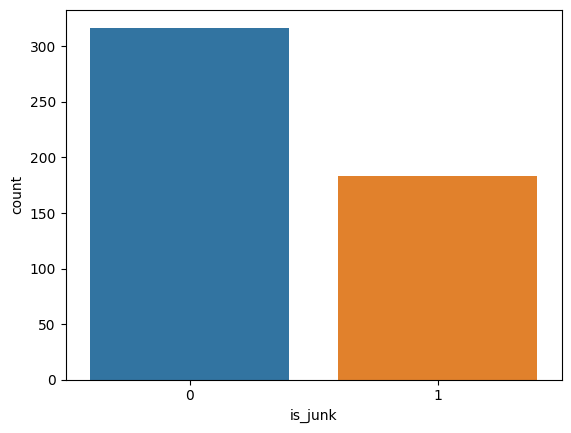

In [15]:
sns.countplot(x=chanel_junk_valid_new["is_junk"])
print(f"Nb junk : {len(chanel_junk_valid_new[chanel_junk_valid_new['is_junk']==1].index)}")
print(f"Nb non junk : {len(chanel_junk_valid_new[chanel_junk_valid_new['is_junk']==0].index)}")

# Ajout de features

### Présence d'un URL

In [5]:
chanel_junk_valid_new['has_URL'] = utilities.get_presence_of_URL(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [5]:
chanel_junk_valid_new.head()

,text,is_junk,has_URL
0,Went to see sweeneytoddbway with joshgroban. I...,0,0.0
1,Citty strolling 💫📷,1,0.0
2,Chanel blue sandals for the summer💙,0,0.0
3,S O P H I E L E G E N D R E\n\nPhotography s...,1,0.0
4,She judges it fr,0,0.0


### Présence de numéros de téléphone

In [6]:
chanel_junk_valid_new['has_phone_number'] = utilities.get_presence_of_phone_numbers(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [10]:
chanel_junk_valid_new.head()

,text,is_junk,has_phone_number
0,Went to see sweeneytoddbway with joshgroban. I...,0,1.0
1,Citty strolling 💫📷,1,1.0
2,Chanel blue sandals for the summer💙,0,1.0
3,S O P H I E L E G E N D R E\n\nPhotography s...,1,1.0
4,She judges it fr,0,1.0


### Présence de symbole monétaire (€, £, $, ...)

In [7]:
chanel_junk_valid_new['has_currency_symbol'] = utilities.get_presence_of_currency_symbol(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [ ]:
chanel_junk_valid_new.head()

### Ratio de mot

In [8]:
chanel_junk_valid_new['word_ratio'] = utilities.get_word_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [7]:
chanel_junk_valid_new.head()

,text,is_junk,word_ratio,caps_ratio
0,The camelia - a long time symbol of Chanel and...,0,0.587302,0.027027
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851,0.000000
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000,0.111111
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500,0.000000
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345,0.545455


### Ratio de caps

In [9]:
chanel_junk_valid_new['caps_ratio'] = utilities.get_caps_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp)

In [6]:
chanel_junk_valid_new.head()

,text,is_junk
0,Went to see sweeneytoddbway with joshgroban. I...,0
1,Citty strolling 💫📷,1
2,Chanel blue sandals for the summer💙,0
3,S O P H I E L E G E N D R E\n\nPhotography s...,1
4,She judges it fr,0


### Ratio de ponctuation

In [10]:
chanel_junk_valid_new['norm_punct'] = utilities.get_normalized_nb_punct(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [13]:
chanel_junk_valid_new.head()

,text,is_junk,has_URL,has_phone_number,has_currency_symbol,word_ratio,caps_ratio,norm_punct
0,Went to see sweeneytoddbway with joshgroban. I...,0,0.0,0,0.0,1.0,0.021277,0.138298
1,Citty strolling 💫📷,1,0.0,0,0.0,1.0,0.000000,0.000000
2,Chanel blue sandals for the summer💙,0,0.0,0,0.0,1.0,0.000000,0.000000
3,S O P H I E L E G E N D R E\n\nPhotography s...,1,0.0,0,0.0,1.0,0.666667,0.000000
4,She judges it fr,0,0.0,0,0.0,1.0,0.000000,0.000000


### Top hashtags junk

In [10]:
s = chanel_junk_valid_new[chanel_junk_valid_new['is_junk']==1]['text']

In [4]:
utilities.top_hashtags(chanel_junk_valid_new['text'],nlp = nlp)

#제니                      8
#シャネル                    4
#ร้านชำของคุณป้าเนโกะ    4
#                        4
#블랙핑크                    3
Name: count, dtype: int64

In [9]:
print('🔥✨🖤')

🔥✨🖤


### Top emojis junk

In [6]:
utilities.top_emojis(chanel_junk_valid_new['text'],nlp=nlp)

🔥    51
✨    46
🖤    35
🌸    33
🤍    32
Name: count, dtype: int64

# Hashtag/emojis dummy

In [11]:
chanel_junk_valid_new = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'emoji',nlp = nlp, top= 3))
chanel_all_features = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'hashtag', nlp = nlp, top= 3))

In [4]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/DATA/chanel_junk_valid_2.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']].dropna()
chanel_junk_valid_new['has_URL'] = utilities.get_presence_of_URL(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_phone_number'] = utilities.get_presence_of_phone_numbers(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_currency_symbol'] = utilities.get_presence_of_currency_symbol(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['word_ratio'] = utilities.get_word_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['caps_ratio'] = utilities.get_caps_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp)
chanel_junk_valid_new['norm_punct'] = utilities.get_normalized_nb_punct(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'emoji',nlp = nlp, top= 3))
chanel_all_features = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'hashtag', nlp = nlp, top= 3))
X_train, X_test, y_train, y_test = train_test_split(chanel_all_features.dropna().drop(['text','is_junk'],axis=1), chanel_all_features.dropna()['is_junk'], test_size=0.2, random_state=42)

In [22]:
chanel_all_features.head()

,text,is_junk,has_URL,has_phone_number,has_currency_symbol,word_ratio,caps_ratio,norm_punct,🔥,❤,💰,#ร้านชำของคุณป้าเนโกะ,#,#シャネル
0,Went to see sweeneytoddbway with joshgroban. I...,0,0.0,0,0.0,1.0,0.021277,0.138298,0,0,0,0,0,0
1,Citty strolling 💫📷,1,0.0,0,0.0,1.0,0.000000,0.000000,0,0,0,0,0,0
2,Chanel blue sandals for the summer💙,0,0.0,0,0.0,1.0,0.000000,0.000000,0,0,0,0,0,0
3,S O P H I E L E G E N D R E\n\nPhotography s...,1,0.0,0,0.0,1.0,0.666667,0.000000,0,0,0,0,0,0
4,She judges it fr,0,0.0,0,0.0,1.0,0.000000,0.000000,0,0,0,0,0,0


# Correlation, boxplot

In [6]:
sns.set_theme(style="whitegrid")
temp_chanel_all_features = pd.DataFrame(chanel_all_features)

# Remplacement des valeurs binaires par 'Yes' et 'No'
temp_chanel_all_features['has_currency_symbol'] = chanel_all_features['has_currency_symbol'].map({1: 'Yes', 0: 'No'})
temp_chanel_all_features['has_phone_number'] = chanel_all_features['has_phone_number'].map({1: 'Yes', 0: 'No'})
temp_chanel_all_features['has_URL'] = chanel_all_features['has_URL'].map({1: 'Yes', 0: 'No'})

temp_chanel_all_features['is_junk'] = chanel_all_features['is_junk'].map({1: 'Yes', 0: 'No'})

C:\Users\a.tekiouk\AppData\Local\Temp\ipykernel_92964\3478830811.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = chanel_all_features.corr()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning:

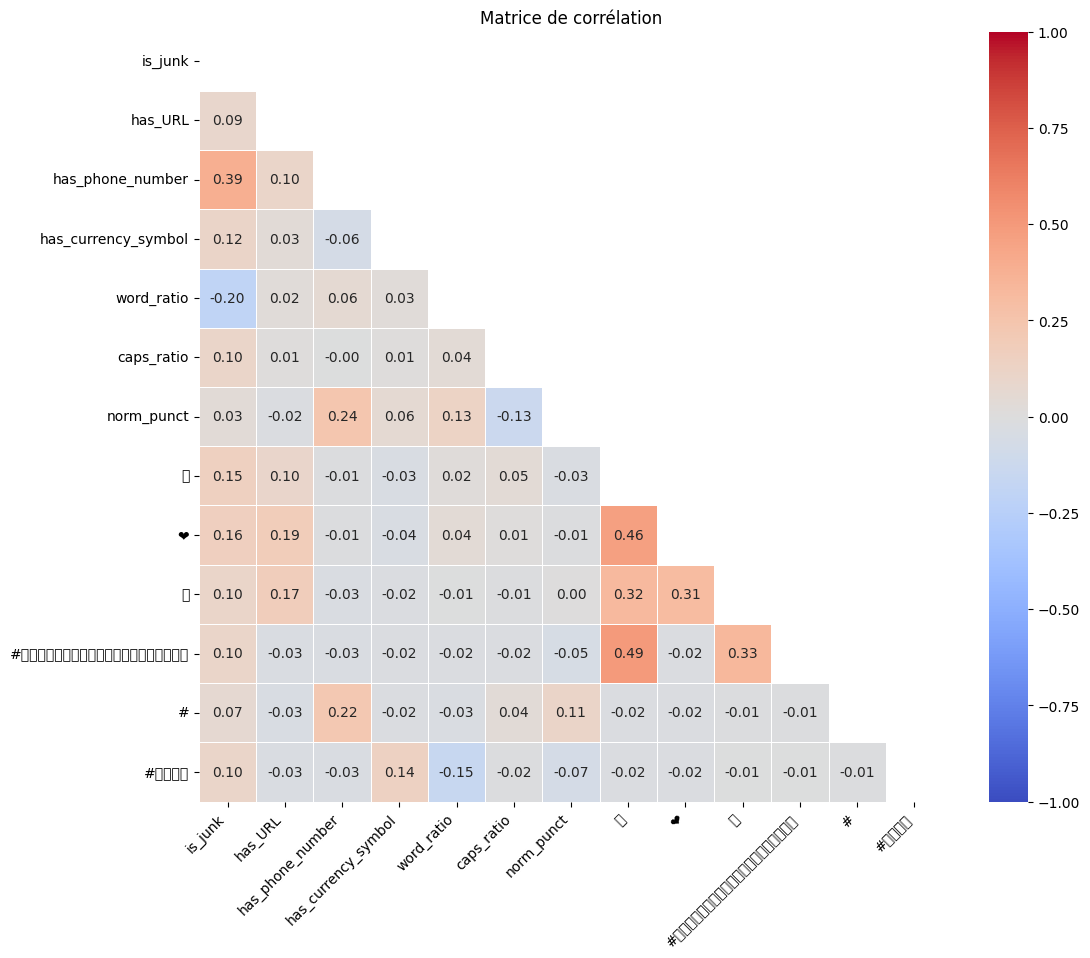

In [23]:
plt.figure(figsize=(12, 10))
corr = chanel_all_features.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', mask=mask, linewidths=0.5, annot_kws={"size": 10},vmin = -1, vmax = 1)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Matrice de corrélation')
plt.show()

[Text(0.5, 1.0, 'Posts count')]

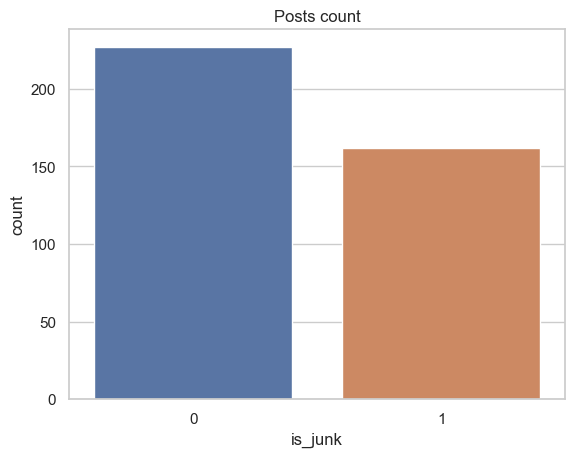

In [16]:
sns.countplot(x=chanel_all_features["is_junk"]).set(title='Posts count')

Boxplot word ratio 

[Text(0, 0.5, 'Word ratio'), Text(0.5, 1.0, 'Boxplot word ratio')]

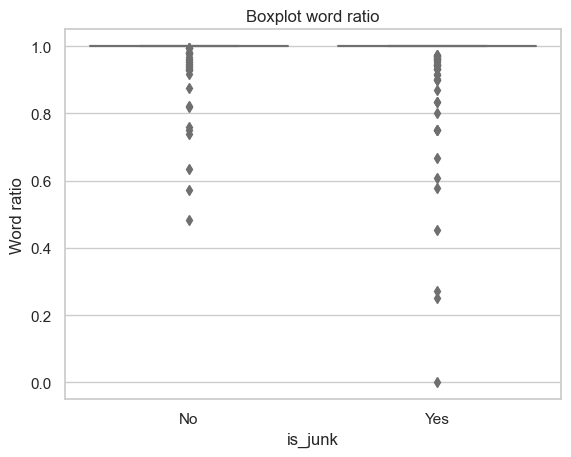

In [54]:
sns.boxplot(data  = temp_chanel_all_features, 
            x     = "is_junk", 
            y     = "word_ratio",
            color = "skyblue").set(ylabel='Word ratio', title = "Boxplot word ratio")

In [13]:
utilities.t_test(chanel_all_features,'word_ratio','is_junk')

t stat : 2.750875233119125

p-value : 0.0064437847660831805


Boxplot caps ratio

[Text(0, 0.5, 'Uppercase ratio'), Text(0.5, 1.0, 'Boxplot uppercase ratio')]

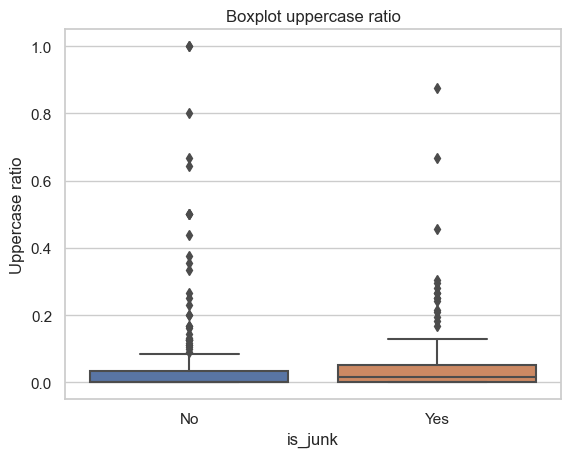

In [55]:
sns.boxplot(data  = temp_chanel_all_features,
            x     = "is_junk",
            y     = "caps_ratio").set(ylabel='Uppercase ratio', title = "Boxplot uppercase ratio")

In [17]:
utilities.t_test(chanel_all_features,'caps_ratio','is_junk')

t stat : -0.5364432524584279

p-value : 0.5919268200881604


Boxplot nb ponctuation

[Text(0, 0.5, 'punctuation ratio'),
 Text(0.5, 1.0, 'Boxplot punctuation ratio')]

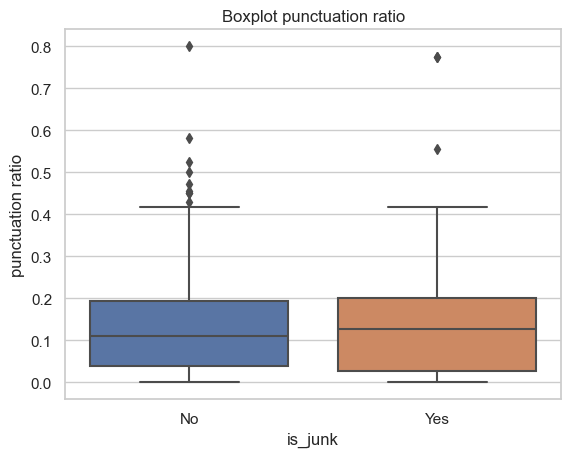

In [56]:
sns.boxplot(data = temp_chanel_all_features,
            x    = "is_junk",
            y    = "norm_punct" ).set(ylabel = 'punctuation ratio', title = "Boxplot punctuation ratio")

In [20]:
utilities.t_test(chanel_all_features,'norm_punct','is_junk')

t stat : -0.2179445094146019

p-value : 0.8275916811081662


graph numéro de téléphone, URL, et symbole monétaire


[Text(0.5, 0, 'Has a phone number in the text'),
 Text(0.5, 1.0, 'Count of junk/non-junk vs having a phone number')]

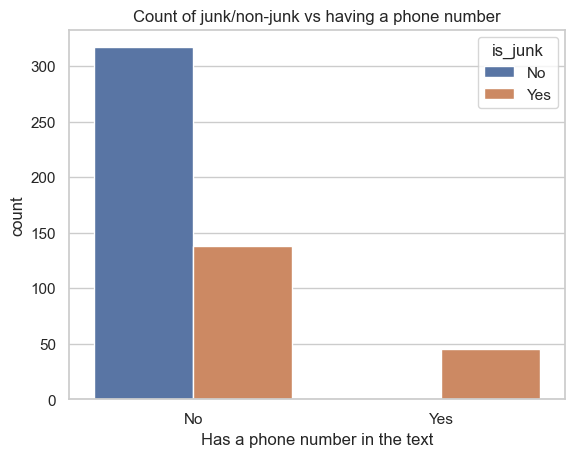

In [57]:
ax1 = sns.countplot(data=temp_chanel_all_features, x='has_phone_number', hue= 'is_junk')
ax1.set(xlabel = "Has a phone number in the text", title = "Count of junk/non-junk vs having a phone number")

In [22]:
chi2_contingency(pd.crosstab(chanel_all_features['has_phone_number'],chanel_all_features['is_junk']))

Chi2ContingencyResult(statistic=82.68408907080882, pvalue=9.627308648408526e-20, dof=1, expected_freq=array([[288.47, 166.53],
       [ 28.53,  16.47]]))

[Text(0.5, 0, 'Has a URL in the text'),
 Text(0.5, 1.0, 'Count of junk/non-junk vs having a URL')]

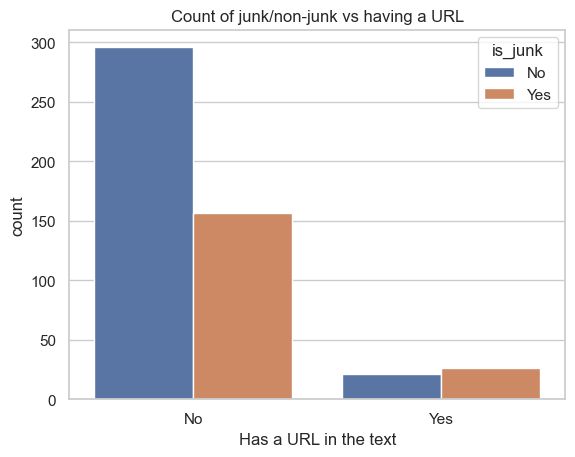

In [58]:
ax2 = sns.countplot(data=temp_chanel_all_features, x='has_URL', hue= 'is_junk')
ax2.set(xlabel = "Has a URL in the text", title = "Count of junk/non-junk vs having a URL")

In [24]:
chi2_contingency(pd.crosstab(chanel_all_features['has_URL'],chanel_all_features['is_junk']))

Chi2ContingencyResult(statistic=6.968679034205408, pvalue=0.008294870821952552, dof=1, expected_freq=array([[287.202, 165.798],
       [ 29.798,  17.202]]))

[Text(0.5, 0, 'Has a currency symbol in the text'),
 Text(0.5, 1.0, 'Count of junk/non-junk vs having a currency symbol')]

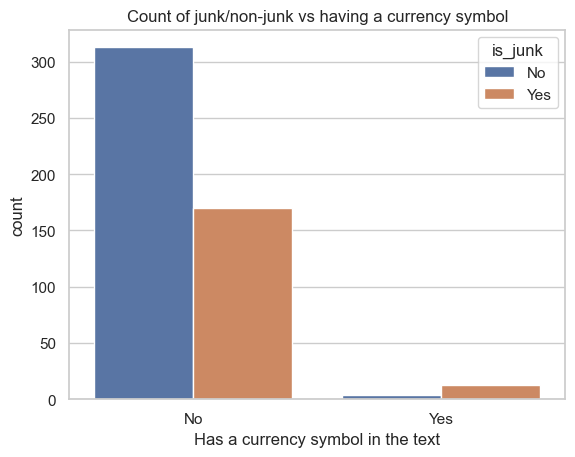

In [59]:
ax3 = sns.countplot(data=temp_chanel_all_features, x='has_currency_symbol', hue= 'is_junk')
ax3.set(xlabel = "Has a currency symbol in the text", title = "Count of junk/non-junk vs having a currency symbol")

In [26]:
chi2_contingency(pd.crosstab(chanel_all_features['has_currency_symbol'],chanel_all_features['is_junk']))

Chi2ContingencyResult(statistic=10.34299302140382, pvalue=0.0012996710024601938, dof=1, expected_freq=array([[306.222, 176.778],
       [ 10.778,   6.222]]))

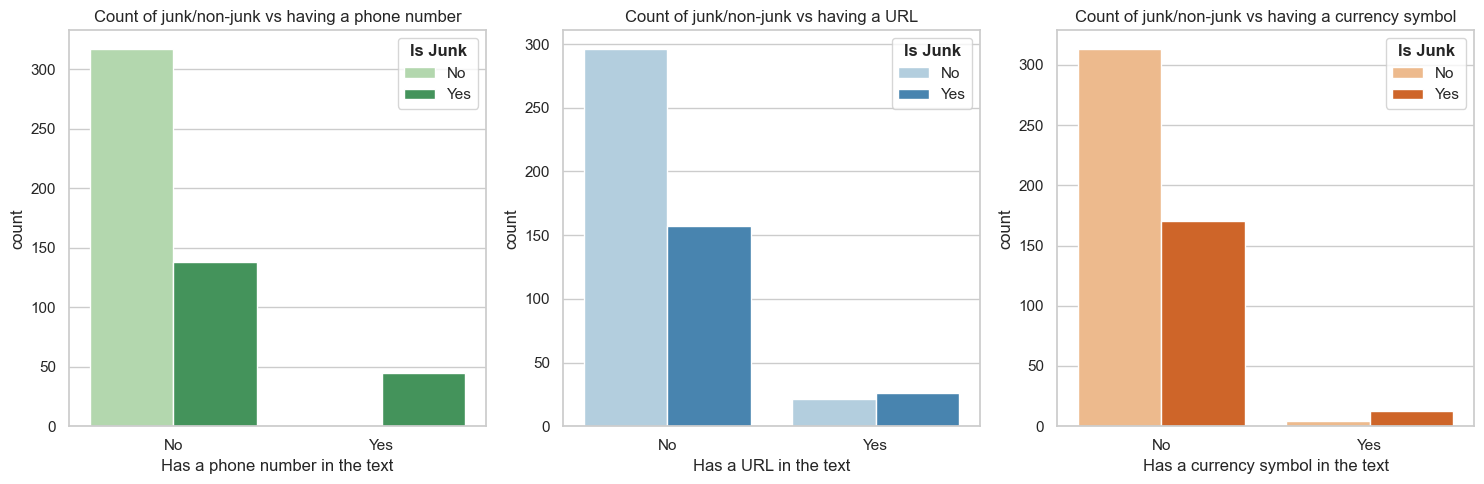

In [10]:

# Créer une figure avec 3 sous-graphiques
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Palette de couleurs pour les graphiques
palette = {0: "green", 1: "blue", 2: "orange"}

# Premier graphique
sns.countplot(data=temp_chanel_all_features, x='has_phone_number', hue='is_junk', ax=ax1, palette="Greens")
ax1.set(xlabel="Has a phone number in the text", title="Count of junk/non-junk vs having a phone number")
legend1 = ax1.legend(title="Is Junk")
legend1.get_title().set_fontweight("bold")

# Deuxième graphique
sns.countplot(data=temp_chanel_all_features, x='has_URL', hue='is_junk', ax=ax2, palette="Blues")
ax2.set(xlabel="Has a URL in the text", title="Count of junk/non-junk vs having a URL")
legend2 = ax2.legend(title="Is Junk")
legend2.get_title().set_fontweight("bold")

# Troisième graphique
sns.countplot(data=temp_chanel_all_features, x='has_currency_symbol', hue='is_junk', ax=ax3, palette="Oranges")
ax3.set(xlabel="Has a currency symbol in the text", title="Count of junk/non-junk vs having a currency symbol")
legend3 = ax3.legend(title="Is Junk")
legend3.get_title().set_fontweight("bold")

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()

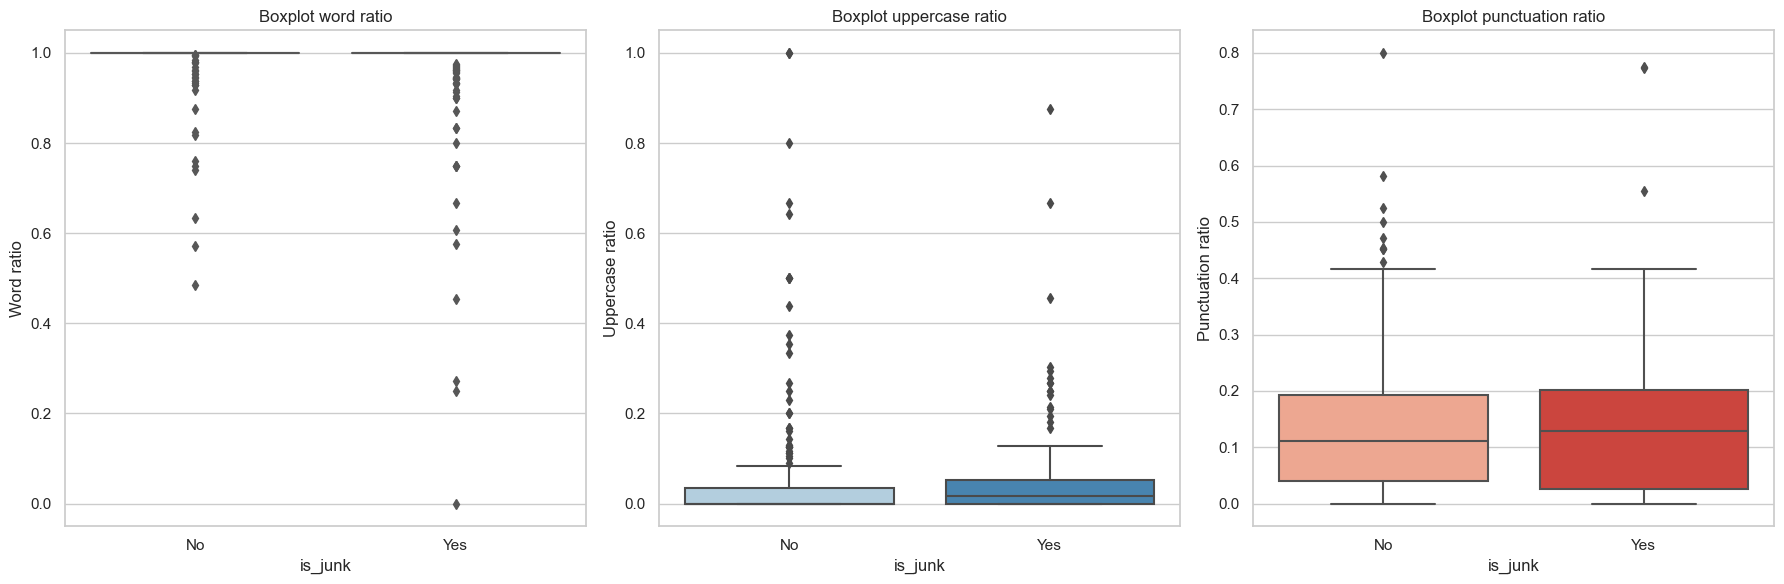

In [24]:

# Création d'une seule figure avec trois sous-graphiques en ligne
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Premier sous-graphique
sns.boxplot(data=temp_chanel_all_features, 
            x="is_junk", 
            y="word_ratio",
            ax=axes[0],
            palette="Purples").set(ylabel='Word ratio', title="Boxplot word ratio")

# Deuxième sous-graphique
sns.boxplot(data=temp_chanel_all_features,
            x="is_junk",
            y="caps_ratio", 
            ax=axes[1],
            palette = "Blues").set(ylabel='Uppercase ratio', title="Boxplot uppercase ratio")

# Troisième sous-graphique
sns.boxplot(data=temp_chanel_all_features,
            x="is_junk",
            y="norm_punct",
            ax=axes[2], 
            palette = "Reds").set(ylabel='Punctuation ratio', title="Boxplot punctuation ratio")


# Ajustements pour un meilleur espacement entre les sous-graphiques
plt.tight_layout()

# Affichage de la figure
plt.show()

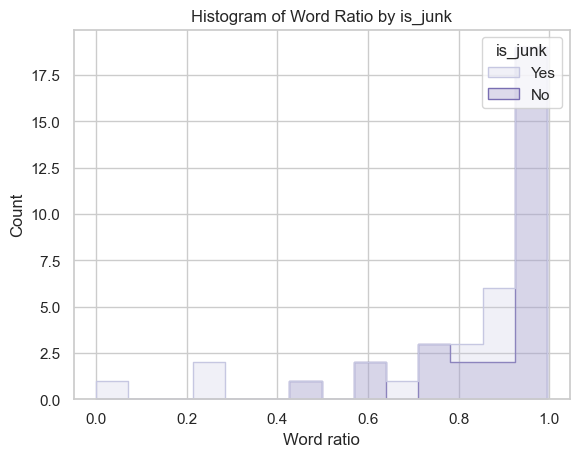

In [16]:
# Créer un sous-ensemble des données où "word_ratio" n'est pas égal à 1
filtered_data = temp_chanel_all_features[temp_chanel_all_features['word_ratio'] != 1]

# Tracer l'histogramme
sns.histplot(data=filtered_data, x="word_ratio", hue="is_junk", element="step", common_norm=False, palette='Purples')
plt.xlabel('Word ratio')
plt.ylabel('Count')
plt.title('Histogram of Word Ratio by is_junk')
# plt.legend(title="is_junk")
plt.show()

# Arbre de decision

In [48]:
#train,test = utilities.train_test(data = chanel_all_features.dropna().drop('text',axis=1), y = 'is_junk', f_y0= 0.7, f_y1= 0.7)
X_train, X_test, y_train, y_test = train_test_split(chanel_all_4features.dropna().drop(['text','is_junk'],axis=1), chanel_all_features.dropna()['is_junk'], test_size=0.30, random_state=42)

Arbre

In [51]:
with open('C:/Users/a.tekiouk/Sujet_2/Models/model_tree_auc_spacy.pkl', 'rb') as f:
     model_tree_auc_spacy = pickle.load(f) # deserialize using load()

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_export.py:676: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  ann.update_bbox_position_size(renderer)


[Text(0.6666666666666666, 0.9375, 'has_phone_number <= 0.5\nentropy = 0.96\nsamples = 350\nvalue = [216, 134]\nclass = 1'),
 Text(0.5555555555555556, 0.8125, '🔥 <= 0.5\nentropy = 0.893\nsamples = 313\nvalue = [216, 97]\nclass = 1'),
 Text(0.3333333333333333, 0.6875, 'word_ratio <= 0.975\nentropy = 0.87\nsamples = 299\nvalue = [212, 87]\nclass = 1'),
 Text(0.2222222222222222, 0.5625, 'entropy = 0.957\nsamples = 37\nvalue = [14, 23]\nclass = 0'),
 Text(0.4444444444444444, 0.5625, 'has_currency_symbol <= 0.5\nentropy = 0.802\nsamples = 262\nvalue = [198, 64]\nclass = 1'),
 Text(0.3333333333333333, 0.4375, 'caps_ratio <= 0.035\nentropy = 0.771\nsamples = 252\nvalue = [195, 57]\nclass = 1'),
 Text(0.2222222222222222, 0.3125, 'norm_punct <= 0.014\nentropy = 0.693\nsamples = 188\nvalue = [153, 35]\nclass = 1'),
 Text(0.1111111111111111, 0.1875, 'entropy = 0.956\nsamples = 45\nvalue = [28, 17]\nclass = 1'),
 Text(0.3333333333333333, 0.1875, 'norm_punct <= 0.311\nentropy = 0.546\nsamples = 143\

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  func(*args, **kwargs)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


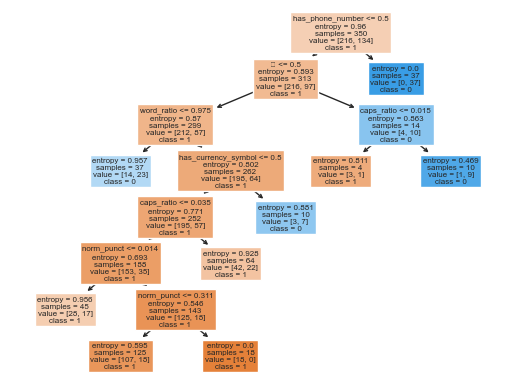

In [52]:
sklearn.tree.plot_tree(model_tree_auc_spacy,feature_names = X_train.columns, class_names = ['1','0'], filled = True)